## Load OpenMeteo Daily Data

In [1]:
import requests
import pandas as pd

locations = {
    'Metzingen' : {'lat':52.67057, 'long':10.37136},
    'Hannover Station 2014':  {'lat':52.4644, 'long':9.6779}
    }

dates = {
      'StartDate': '2022-01-01',
      'EndDate': '2024-11-11'
    }

loc = 'Hannover Station 2014'

openmeteo = f'https://archive-api.open-meteo.com/v1/archive?latitude={locations[loc]["lat"]}&longitude={locations[loc]["long"]}&start_date={dates["StartDate"]}&end_date={dates["EndDate"]}&daily=sunshine_duration,rain_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant&timezone=GMT'

res = requests.get(openmeteo)
if res.status_code == 200:
  data = res.json()



for k in data['daily_units']:
  print(k,data['daily_units'][k])


df = pd.DataFrame(data['daily'], columns= data['daily_units'])

df.head()


time iso8601
sunshine_duration s
rain_sum mm
wind_speed_10m_max km/h
wind_gusts_10m_max km/h
wind_direction_10m_dominant °


,time,sunshine_duration,rain_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2022-01-01,2845.71,0.2,21.9,42.1,235
1,2022-01-02,6733.11,5.3,29.2,55.1,229
2,2022-01-03,12927.33,4.1,33.4,63.7,249
3,2022-01-04,0.00,2.8,20.2,36.7,248
4,2022-01-05,7422.81,2.1,33.0,67.3,256


## Load DWD measurements for Hannover and Bremen

* original download: https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivtagmonat.html
* download 2 zips and exctract the files `produkt_klima_tag*.txt` to a local folder `../data/wetter_dwd`

In [2]:
import os
import json
from datetime import datetime
from pathlib import Path

# Filename changes...
Hannover_daily = pd.read_csv(os.path.abspath('').replace("\\","/").replace('wetter','data/wetter_dwd/produkt_klima_tag_20230514_20241113_02014.txt'), sep=";")
Bremen_daily = pd.read_csv(os.path.abspath('').replace("\\","/").replace('wetter','data/wetter_dwd/produkt_klima_tag_20230514_20241113_00691.txt'), sep=";")

#dwd_params = pd.read_csv('/content/drive/MyDrive/DWD_data/Metadaten_Parameter_klima_tag_02014.txt', sep=";", encoding = "ISO-8859-1")
#params = dwd_params[dwd_params['Bis_Datum'] > 20240101][['Parameter','Parameterbeschreibung']].set_index('Parameter')['Parameterbeschreibung'].to_dict()
#print (json.dumps(params, indent=4))
params = """{
    "FM": "Tagesmittel der Windgeschwindigkeit m/s  Messnetz 3",
    "FX": "Maximum der Windspitze Messnetz 3",
    "NM": "Tagesmittel des Bedeckungsgrades",
    "PM": "Tagesmittel des Luftdrucks",
    "RSK": "tgl. Niederschlagshoehe",
    "RSKF": "tgl. Niederschlagsform (=Niederschlagshoehe_ind)",
    "SDK": "Sonnenscheindauer Tagessumme",
    "SHK_TAG": "Schneehoehe Tageswert",
    "TGK": "Minimum der Lufttemperatur am Erdboden in 5cm Hoehe",
    "TMK": "Tagesmittel der Temperatur",
    "TNK": "Tagesminimum der Lufttemperatur in 2m Hoehe",
    "TXK": "Tagesmaximum der Lufttemperatur in 2m Hoehe",
    "UPM": "Tagesmittel der Relativen Feuchte",
    "VPM": "Tagesmittel des Dampfdruckes"
}"""

def make_time(mess_datum):
    x = str(mess_datum)
    return x[:4]+'-'+ x[4:6]+'-'+ x[6:8]

def process_dwd_daily(df, suffix=''):
  dwd_daily =df.copy(deep=True)
  dwd_daily['time'] = dwd_daily.apply(lambda row:  make_time(row['MESS_DATUM']),axis=1)
  dwd_daily['Weekday'+suffix] = dwd_daily.apply(lambda row:datetime.strftime(datetime.strptime(row['time'],'%Y-%m-%d'),'%a'), axis=1)
  dwd_daily = dwd_daily[dwd_daily['Weekday'+suffix].isin(['Sat','Sun'])]
  dwd_daily.rename(columns={k:k.strip() for k in dwd_daily.columns.values},inplace=True)
  dwd_daily['dwd_wind'+suffix] = dwd_daily.apply(lambda row: 3.6*row['FM'], axis=1)
  dwd_daily['dwd_gust'+suffix] = dwd_daily.apply(lambda row: 3.6*row['FX'], axis=1)
  dwd_daily['dwd_sun'+suffix] = dwd_daily.apply(lambda row: 3600*row['SDK'], axis=1)

  return dwd_daily

Hannover_daily = process_dwd_daily(Hannover_daily)
Bremen_daily = process_dwd_daily(Bremen_daily,'B')

merged_wetter = Hannover_daily[['time'] + ['dwd_sun','RSK','dwd_wind','dwd_gust']].merge( df, on='time', how='left').merge(Bremen_daily, on='time', how='inner')
merged_wetter.rename(columns={'sunshine_duration':'sun','rain_sum':'rain','wind_speed_10m_max':'wind','wind_gusts_10m_max':'gust','wind_direction_10m_dominant':'dir'},inplace=True)
print(merged_wetter.columns.values)
merged_wetter.head()

['time' 'dwd_sun' 'RSK_x' 'dwd_wind' 'dwd_gust' 'sun' 'rain' 'wind' 'gust'
 'dir' 'STATIONS_ID' 'MESS_DATUM' 'QN_3' 'FX' 'FM' 'QN_4' 'RSK_y' 'RSKF'
 'SDK' 'SHK_TAG' 'NM' 'VPM' 'PM' 'TMK' 'UPM' 'TXK' 'TNK' 'TGK' 'eor'
 'WeekdayB' 'dwd_windB' 'dwd_gustB' 'dwd_sunB']


,time,dwd_sun,RSK_x,dwd_wind,dwd_gust,sun,rain,wind,gust,dir,...,TMK,UPM,TXK,TNK,TGK,eor,WeekdayB,dwd_windB,dwd_gustB,dwd_sunB
0,2023-05-14,41400.0,0.0,9.72,39.96,51144.92,0.4,11.4,27.0,89,...,15.6,62.0,21.6,7.5,4.6,eor,Sun,8.64,33.48,34200.0
1,2023-05-20,10800.0,0.0,18.00,45.72,30853.44,0.0,21.3,45.0,71,...,14.5,62.0,18.5,9.3,8.1,eor,Sat,19.80,42.48,28080.0
2,2023-05-21,17640.0,0.0,14.76,37.08,35297.32,0.9,17.7,36.4,76,...,18.4,69.0,25.9,11.3,10.3,eor,Sun,13.32,30.24,10440.0
3,2023-05-27,51480.0,0.0,7.20,30.24,53274.95,0.0,10.1,24.1,77,...,14.6,68.0,21.8,5.7,2.9,eor,Sat,7.20,33.48,51120.0
4,2023-05-28,51120.0,0.0,8.28,33.48,53401.25,0.0,17.4,37.4,33,...,15.5,68.0,22.1,9.1,6.3,eor,Sun,13.68,41.40,49320.0


## Compared measurements (DWD) and computed (OpenMeteo) daily data

* Especially the average wind and the sunny hours are systematically OVERESTIMATED by OpenMeteo
* For measurements the difference between Hannover and Bremen is smaller than the difference between measurements and OpenMeteo data for Hannover

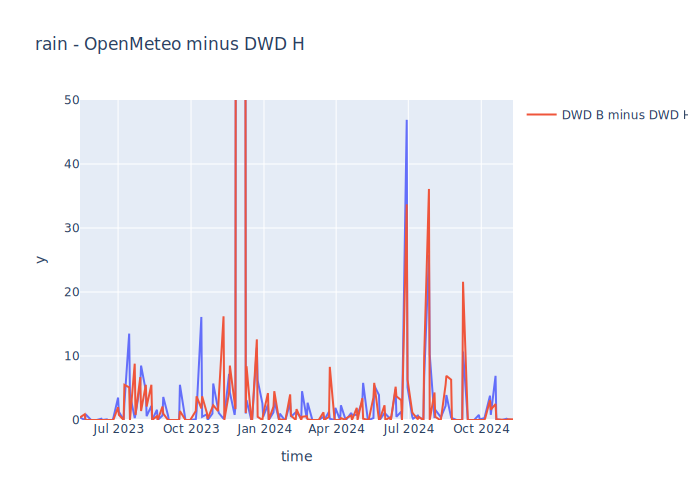

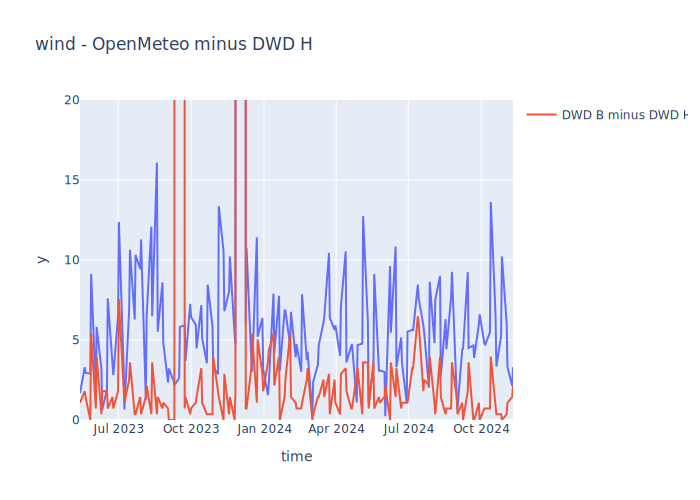

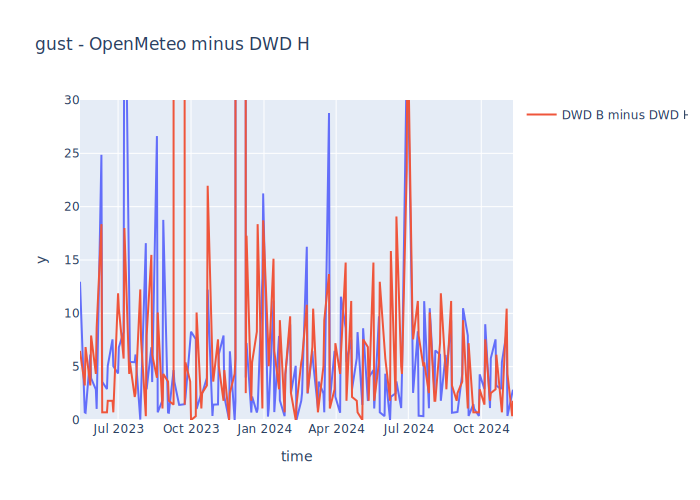

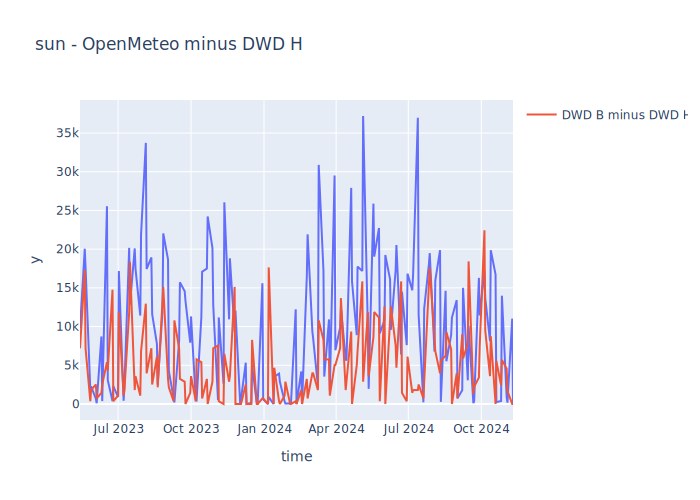

In [20]:
import numpy as np
import plotly.express as px

fig = px.line(merged_wetter, x="time", y=np.absolute(merged_wetter["rain"]-merged_wetter["RSK_x"]),title="rain - OpenMeteo minus DWD H")
fig.add_scatter(x=merged_wetter['time'], y=np.absolute(merged_wetter['RSK_y']-merged_wetter["RSK_x"]), name='DWD B minus DWD H')
fig.update_layout(yaxis_range=[0,50])
fig.show('svg')

fig = px.line(merged_wetter, x="time", y=np.absolute(merged_wetter["wind"]-merged_wetter["dwd_wind"]),title="wind - OpenMeteo minus DWD H")
fig.add_scatter(x=merged_wetter['time'], y=np.absolute(merged_wetter['dwd_windB']-merged_wetter["dwd_wind"]), name='DWD B minus DWD H')
fig.update_layout(yaxis_range=[0,20])
fig.show('svg')

fig = px.line(merged_wetter, x="time", y=np.absolute(merged_wetter["gust"]-merged_wetter["dwd_gust"]),title="gust - OpenMeteo minus DWD H")
fig.add_scatter(x=merged_wetter['time'], y=np.absolute(merged_wetter['dwd_gustB']-merged_wetter["dwd_gust"]), name='DWD B minus DWD H')
fig.update_layout(yaxis_range=[0,30])
fig.show('svg')


fig = px.line(merged_wetter, x="time", y=np.absolute(merged_wetter["sun"]-merged_wetter["dwd_sun"]),title="sun - OpenMeteo minus DWD H")
fig.add_scatter(x=merged_wetter['time'], y=np.absolute(merged_wetter['dwd_sunB']-merged_wetter["dwd_sun"]), name='DWD B minus DWD H')
#fig.update_layout(yaxis_range=[-30,30])
fig.show('svg')

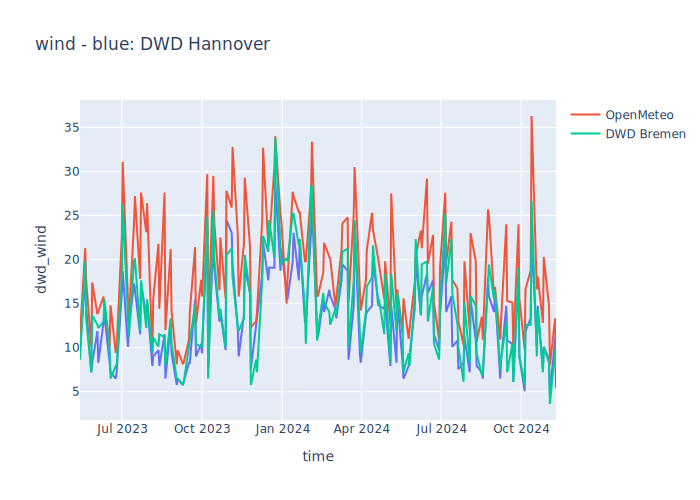

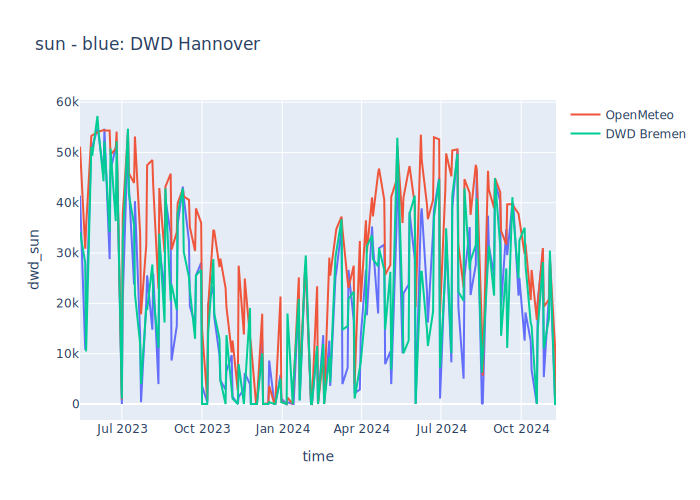

In [22]:
import plotly.express as px

fig = px.scatter(merged_wetter[merged_wetter['RSK_x']>=0], x="time", y="RSK_x",title="rain - blue: DWD Hannover")

fig.add_scatter(x=merged_wetter['time'], y=merged_wetter['rain'],mode='markers', name='OpenMeteo')
fig.add_scatter(x=Bremen_daily['time'], y=Bremen_daily['RSK'],mode='markers', name='DWD Bremen')

#fig.show()

fig = px.line(merged_wetter[merged_wetter['dwd_wind']>=0], x="time", y="dwd_wind",title="wind - blue: DWD Hannover")

fig.add_scatter(x=merged_wetter['time'], y=merged_wetter['wind'], name='OpenMeteo')
fig.add_scatter(x=Bremen_daily[Bremen_daily['dwd_windB']>=0]['time'], y=Bremen_daily[Bremen_daily['dwd_windB']>=0]['dwd_windB'], name='DWD Bremen')

fig.show('svg')

fig = px.line(merged_wetter[merged_wetter['dwd_gust']>=0], x="time", y="dwd_gust",title="gust - blue: DWD Hannover")

fig.add_scatter(x=merged_wetter['time'], y=merged_wetter['gust'], name='OpenMeteo')
fig.add_scatter(x=Bremen_daily[Bremen_daily['dwd_gustB']>=0]['time'], y=Bremen_daily[Bremen_daily['dwd_gustB']>=0]['dwd_gustB'], name='DWD Bremen')

#fig.show()

fig = px.line(merged_wetter[merged_wetter['dwd_sun']>=0], x="time", y="dwd_sun",title="sun - blue: DWD Hannover")

fig.add_scatter(x=merged_wetter['time'], y=merged_wetter['sun'], name='OpenMeteo')
fig.add_scatter(x=Bremen_daily[Bremen_daily['dwd_sunB']>=0]['time'], y=Bremen_daily[Bremen_daily['dwd_sunB']>=0]['dwd_sunB'], name='DWD Bremen')

fig.show('svg')

## Get DHV XC flight data

* Metzingen
* Lüdingen
* Leese, Estorf (GC Landesbergen)

In [2]:
import requests
import urllib
import pandas as pd

PAGE_SIZE = 500

places = {
    'Metzingen':11185,
    'Rammelsberg': 9427,
    'Estorf': 11001,
    'Leese': 10746,
    'Porta': 9712,
    'Lüdingen':9759,
    'Brunsberg': 9844,
    'Kella': 9521,
    'Börry': 9403
}

results = []
for place in ['Metzingen','Estorf','Leese','Lüdingen']:
#for place in ['Metzingen']:
    limit = PAGE_SIZE
    for start in [0,PAGE_SIZE]:
        query = {"navpars":{"start":start,"limit":limit,"sort":[{"field":"FlightDate","dir":-1},{"field":"BestTaskPoints","dir":-1}]}}
        # for some reason, " is replaced by ' and spaces are added which is replaced by +
        decoded_url = f"https://de.dhv-xc.de/api/fli/flights?s?fkcat%5B%5D=1&fkto%5B%5D={places[place]}&{urllib.parse.urlencode(query,quote_via=urllib.parse.quote_plus).replace('%27', '%22').replace('+', '')}"
        #print(decoded_url)
        r = requests.get(decoded_url)
        if r.status_code==200:
            response = r.json()
            df0 = pd.DataFrame(response['data'])
            #print(df.columns.values)
            results.extend(df0[['FlightDate', 'TakeoffWaypointName' , 'Glider' ,'FlightDuration','UtcOffset', 'FlightStartTime']].values)


df_results = pd.DataFrame(results,columns=['FlightDate','Takeoff', 'Glider' ,'Duration','UtcOffset', 'FlightStartTime'])
print(len(df_results))
df_results.tail()

4000


,FlightDate,Takeoff,Glider,Duration,UtcOffset,FlightStartTime
3995,2021-04-20,Lüdingen,Arriba 3 S,513,2,2021-04-20 16:43:38
3996,2021-04-20,Lüdingen,MiuraRS - ML [LTF A],516,2,2021-04-20 20:02:08
3997,2021-04-20,Lüdingen,BuzzZ5,576,2,2021-04-20 13:36:34
3998,2021-04-20,Lüdingen,MiuraRS - ML [LTF A],477,2,2021-04-20 15:39:31
3999,2021-04-20,Lüdingen,Alpha 6,533,2,2021-04-20 15:50:03


## Merge weather and flight data for training and testing

* Weather data : OpenMeteo daily @ Hannover
* Flight data: Sundays and Saturdays, all 4 locations

* Training data < 2024
* Test data >= 2024

In [3]:
import numpy as np
from datetime import datetime
print(loc, locations[loc])
df['Weekday'] = df.apply(lambda row:datetime.strftime(datetime.strptime(row['time'],'%Y-%m-%d'),'%a'), axis=1)
df['alignment'] =  df.apply(lambda row: np.cos(row['wind_direction_10m_dominant']*np.pi/180.)**2,axis=1)
df = df[df['Weekday'].isin(['Sat','Sun'])]
#print(df.head())

dhv_aggr = df_results[df_results['FlightDate'] >= '2022-01-01'].groupby('FlightDate')['Duration'].count().reset_index()
dhv_aggr['Weekday'] = dhv_aggr.apply(lambda row:  datetime.strftime(datetime.strptime(row['FlightDate'],'%Y-%m-%d'),'%a'), axis=1)
dhv_aggr.rename(columns={'FlightDate':'time'},inplace=True)
#dhv_aggr.head()

dfm = df.merge(dhv_aggr, on='time', how='left')
dfm.rename(columns={'sunshine_duration':'sun','rain_sum':'rain','wind_speed_10m_max':'wind','wind_gusts_10m_max':'gust','wind_direction_10m_dominant':'dir','Duration':'flights'},inplace=True)
dfm = dfm.drop(['Weekday_y'] ,axis=1).fillna(0)

Hannover Station 2014 {'lat': 52.4644, 'long': 9.6779}


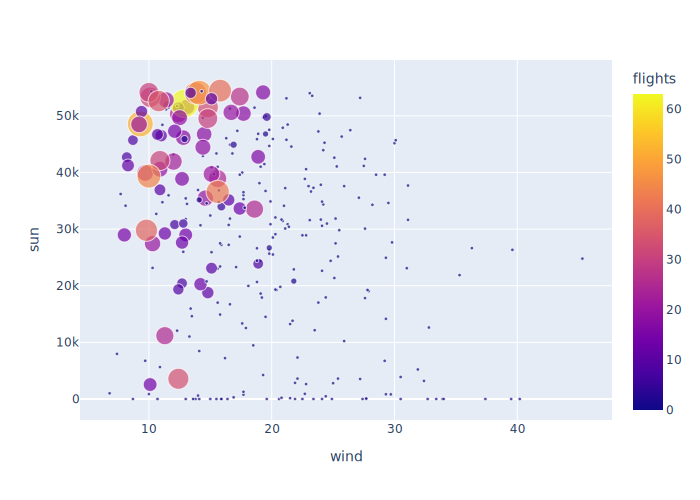

In [4]:
import plotly.express as px 
dfm['size']= dfm.apply(lambda row: row['flights']+1, axis=1)
fig = px.scatter(dfm, x='wind', y='sun', hover_data=['gust','rain','dir','sun','time'], size='size', color='flights')

fig.show('svg')


## Train model

* RandomForestRegressor with 200 estimators (decision trees)

In [5]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np

features = ['wind','gust','rain','sun']

test_filter =(dfm['time'] >= '2024-01-01')
train_filter = (dfm['time'] < '2024-01-01') & (dfm['time'] >= '2023-01-01')
xtrain = dfm[train_filter][features].to_numpy()
ytrain = dfm[train_filter]['flights'].to_numpy()

print(np.shape(xtrain),np.shape(ytrain))

# TODO include threshold value to be optimized
regr = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,max_features=0.5)
regr.fit(xtrain,ytrain)


dfm['predict'] = dfm[test_filter | train_filter].apply(lambda row: regr.predict([row[features].to_numpy()])[0], axis=1)

(105, 4) (105,)


## Evaluate

* Choose some threshold to define categories
* Calculate  measures

In [6]:
thr = 4.

tp = dfm[test_filter & (dfm['flights'] > 0) & (dfm['predict'] >= thr)]
tn = len(dfm[test_filter & ~(dfm['flights'] > 0) & ~(dfm['predict'] >= thr)])
fp = dfm[test_filter & ~(dfm['flights'] > 0) & (dfm['predict'] >= thr)]
fn = dfm[test_filter & (dfm['flights'] > 0) & ~(dfm['predict'] >= thr)]

print('true pos', len(tp))
print('true neg', tn)
print('false pos', len(fp))
print('false neg', len(fn))

print('precision:', len(tp)/(len(tp)+len(fp)), 'recall:', len(tp)/(len(tp)+len(fn)) )
#print("true positives","\n", tp.to_markdown())
print("\nfalse negatives\n\n", fn.to_markdown())
print("\nfalse positives\n\n",fp.to_markdown())

true pos 20
true neg 59
false pos 7
false neg 4
precision: 0.7407407407407407 recall: 0.8333333333333334

false negatives

 |     | time       |     sun |   rain |   wind |   gust |   dir | Weekday_x   |   alignment |   flights |   size |   predict |
|----:|:-----------|--------:|-------:|-------:|-------:|------:|:------------|------------:|----------:|-------:|----------:|
| 217 | 2024-01-28 | 26696.7 |    0   |   19.8 |   35.6 |   158 | Sun         |   0.85967   |         2 |      3 |  0.916881 |
| 235 | 2024-03-31 | 20265.4 |    3.1 |   14.2 |   26.3 |    97 | Sun         |   0.0148521 |        13 |     14 |  2.99608  |
| 241 | 2024-04-21 | 46795.8 |    0.8 |   19.5 |   41.4 |    49 | Sun         |   0.430413  |         2 |      3 |  0.419802 |
| 287 | 2024-09-29 | 36581.2 |    0.1 |   15.6 |   28.4 |   209 | Sun         |   0.76496   |        42 |     43 |  3.58852  |

false positives

 |     | time       |      sun |   rain |   wind |   gust |   dir | Weekday_x   |   alignment | 

## Next steps:

* generate born-again decision tree from the trained random forest
* visualize/use this data

## Ensemble characteristics

In [7]:
import numpy as np 
np.set_printoptions(precision=4, suppress=True)
 
print(features)
#print(regr.feature_names_in_)
print(regr.feature_importances_)

feature_space = {f:set() for f in features }
for rt in regr.estimators_[:200]:
    #https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
    #print(rt)
    tree = rt.tree_
    #print(f"tree node count: {tree.node_count}")
    for i in range(tree.node_count):
        if tree.children_left[i]!=tree.children_right[i]:
            #print(tree.feature[i], tree.threshold[i])
            feature_space[features[tree.feature[i]]].add(tree.threshold[i])
        #else:
        #    print('leaf node')

for f in feature_space:
    print(f, len(feature_space[f]),min(feature_space[f]),max(feature_space[f]))

# heuristic algo from https://arxiv.org/pdf/2003.11132 ?
# "low" lowest corner and "up" upper corner
XL, XU =  dfm[test_filter | train_filter][features].aggregate(['min','max']).to_numpy()
print(f'L: {regr.predict([XL])[0] >= thr} @ {XL}\nR: {regr.predict([XU])[0] >= thr} @ {XU}')
#XM = 0.5*(XL+XU)
#print(f'M: {regr.predict([XM])[0] >= thr} @ {XM}') # False



['wind', 'gust', 'rain', 'sun']
[0.253  0.1972 0.0636 0.4862]
wind 84 8.150000095367432 22.300000190734863
gust 77 16.75 43.95000076293945
rain 28 0.05000000074505806 4.849999904632568
sun 111 15711.15478515625 54398.44921875
L: True @ [ 8.  15.1  0.   0. ]
R: True @ [   36.3    73.1    20.5 54446.2]
